In [1]:
import numpy as np
import scipy
from math import * 
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm
import copy
%matplotlib inline

success


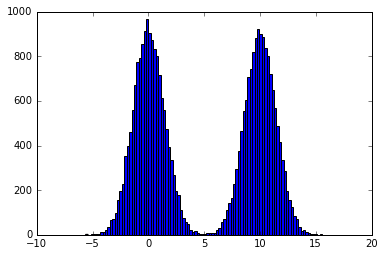

In [2]:
# generate training data set
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 10
num_samples = 30000

X = np.zeros(num_samples)
for i in xrange(num_samples):
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# visualize the data
plt.figure()
plt.hist(X, bins = 100)
print 'success'

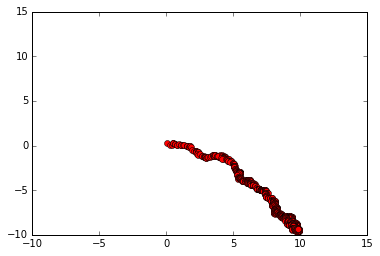

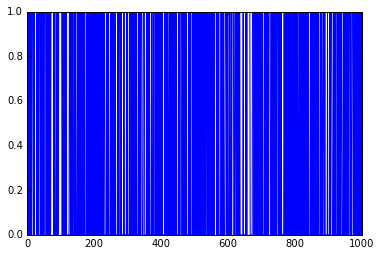

percentage of acceptance:
0.429


In [3]:
def eval_gradient_ll(x, theta, sigmax):
    # compute the gradient value of log(p(x|\theta)) over \theta
    p_x_theta = 0.5 * scipy.stats.norm.pdf(x, theta[0], sigmax) + 0.5 * scipy.stats.norm.pdf(x, theta[0]+theta[1], sigmax)
    grad_theta_0 = 0.5 * scipy.stats.norm.pdf(x,theta[0], sigmax)*(x-theta[0])/(sigmax**2) + 0.5 * scipy.stats.norm.pdf(x, theta[0]+theta[1], sigmax)*(x-theta[0]-theta[1])/(sigmax**2)
    grad_theta_1 = 0.5 * scipy.stats.norm.pdf(x, theta[0]+theta[1],sigmax)*(x-theta[0]-theta[1])/(sigmax**2)
    grad_log_theta0 = grad_theta_0/p_x_theta
    grad_log_theta1 = grad_theta_1/p_x_theta
    return [grad_log_theta0, grad_log_theta1]

def langevin_proposer(theta_t, alpha, Xn, N, sigma, sigmax):
    # this function propose new parameters based on langevin dynamics 
    # and test whether to accept new proposed theta' or not
    # input: theta_t: previous parameter value
    #        alpha  : alpha value in langevin proposer
    #        Xn     : the mini-batch sample used to propose new parameters
    #        N      : the size of entire data set
    #        sigma  : standard deviation for prior distribution of theta
    #        sigmax : standard deviation of the distribution of data
    
    # evaluate the gradient over the original parameter set theta_t
    grad_log_rho_theta_t = [-1*theta_t[0]/(sigma[0]**2), -1*theta_t[1]/(sigma[1]**2)]
    grad_log_p_x_theta_t = [0,0]
    grad_theta_t = [0,0]
    for i in range(len(Xn)):
        mid = eval_gradient_ll(Xn[i], theta_t, sigmax)
        grad_log_p_x_theta_t[0] = grad_log_p_x_theta_t[0] + mid[0]
        grad_log_p_x_theta_t[1] = grad_log_p_x_theta_t[1] + mid[1]
    
    grad_log_p_x_theta_t = [1/len(Xn)*N*xx for xx in grad_log_p_x_theta_t]
    grad_theta_t[0] = alpha/2 * (grad_log_p_x_theta_t[0] + grad_log_rho_theta_t[0])
    grad_theta_t[1] = alpha/2 * (grad_log_p_x_theta_t[1] + grad_log_rho_theta_t[1])
    
    # generate new theta'
    theta_n = [0,0]
    theta_n[0] = np.random.normal(theta_t[0]+grad_theta_t[0], sqrt(alpha))
    theta_n[1] = np.random.normal(theta_t[1]+grad_theta_t[1], sqrt(alpha))
    
    return (theta_n,grad_theta_t)
    
def compute_U0(theta_t, theta_n, N, sigma, grad_theta_t, grad_theta_n, alpha):
    u = np.random.uniform()
    rho_theta_t = scipy.stats.norm.pdf(theta_t[0], 0, sigma[0])*scipy.stats.norm.pdf(theta_t[1],0,sigma[1])
    rho_theta_n = scipy.stats.norm.pdf(theta_n[0], 0, sigma[0])*scipy.stats.norm.pdf(theta_n[1],0,sigma[1])
    q_n_t = scipy.stats.norm.pdf(theta_n[0], theta_t[0]+grad_theta_t[0], sqrt(alpha))
    q_t_n = scipy.stats.norm.pdf(theta_t[0], theta_n[0]+grad_theta_n[0], sqrt(alpha))
    U0 = 1/N *log(u*rho_theta_t*q_n_t/(rho_theta_n*q_t_n))
    return U0

def compute_L(x, theta_t, theta_n, sigmax):
    p_x_theta_t = 0.5 * scipy.stats.norm.pdf(x, theta_t[0], sigmax) + 0.5 * scipy.stats.norm.pdf(x, theta_t[0]+theta_t[1], sigmax)
    p_x_theta_n = 0.5 * scipy.stats.norm.pdf(x, theta_n[0], sigmax) + 0.5 * scipy.stats.norm.pdf(x, theta_n[0]+theta_n[1], sigmax)
    L = log(p_x_theta_n) - log(p_x_theta_t)
    return L

def make_decision(L, U0, N):
    n = float(len(L))
    l_mean = sum(L)/n
    L_array = np.array(L)
    l_sq_array = L_array**2
    l_sq = l_sq_array.tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean-l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n)*sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
    
def generate_theta(X, theta_t, n, m, sigma, sigmax, epsilon,alpha):
    N = len(X)
    X_array = np.array(X)
    index = np.random.permutation(N)
    index_Xn = index[0:n]
    Xn = X_array[index_Xn].tolist()
    
    # propose new parameters
    (theta_n, grad_theta_t) = langevin_proposer(theta_t, alpha, Xn, N, sigma, sigmax)
    
    (theta_s, grad_theta_n) = langevin_proposer(theta_n, alpha, Xn, N, sigma, sigmax)
    # decide
    U0 = compute_U0(theta_t, theta_n, N, sigma, grad_theta_t, grad_theta_n, alpha)
    
    l_list = []
    for i in range(m):
        mid = compute_L(X[i], theta_t, theta_n, sigmax)
        l_list.append(mid)
    
    delta = make_decision(l_list, U0, N)
    ii = m-1
    while(delta>epsilon) and (ii < N-m):
        for i in range(ii, ii+m):
            mid = compute_L(X[ii], theta_t, theta_n, sigmax)
            l_list.append(mid)
        ii = ii + m
        delta = make_decision(l_list, U0, N)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0 :
        return (theta_n, 1)
    else:
        return (theta_t, 0)

def train(X, sigma, sigmax, epsilon, n, m, a,b, niter):
    theta1_start = np.random.random()
    theta2_start = np.random.random()
    theta_t = [theta1_start, theta2_start]
    theta1_list = [theta1_start]
    theta2_list = [theta2_start]
    N = len(X)
    accept = []
    for iter in range(niter):
        alpha = a*(b + iter)**(-1*0.55)
        X_array = np.array(X)
        index = np.random.permutation(N)
        X = X_array[index].tolist()
        (res, mid)= generate_theta(X, theta_t,n,m,sigma, sigmax,epsilon,alpha)
        theta1_list.append(res[0])
        theta2_list.append(res[1])
        accept.append(mid)
        theta_t = copy.deepcopy(res)
    
    return (theta1_list, theta2_list, accept)


# train
sigma = [sqrt(sigma1_sq), sqrt(sigma2_sq)]
sigmax = sqrt(sigmax_sq)
batchsize_proposer = 1000
batchsize_decider = 10
a = 0.17
b = 160
niter = 1000
(theta1_list, theta2_list, accept) = train(X, sigma, sigmax, 0.01, batchsize_proposer, batchsize_decider, a, b, niter)


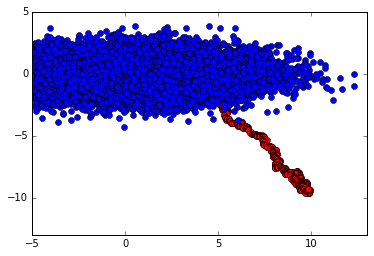

"\nplt.figure()\nplt.plot(accept,'bo')\nplt.show(accept)\nprint 'percentage of acceptance:' \nprint sum(accept)/float(len(accept))\n"

In [10]:
# generate theta space
theta1 = np.zeros(num_samples)
theta2 = np.zeros(num_samples)
for i in xrange(num_samples):
    theta1[i] = np.random.normal(0, np.sqrt(sigma1_sq))
    theta2[i] = np.random.normal(0, np.sqrt(sigma2_sq))


# plot
plt.figure()
plt.plot(theta1_list, theta2_list,'ro') # estimated value
plt.hold(True)
plt.plot(theta1,theta2,'bo')
plt.axis([-5, 13, -13, 5])
plt.show()